In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [2]:
diamonds = pd.read_csv('diamonds.csv' ,index_col = 0)
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [143]:
diamonds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53940 entries, 1 to 53940
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.5+ MB


Great! There is no null values

Attributes or features could be classified to quantitative data type and categorical data type

Quantitative data are : Carat, Depth, Table, Price, x, y and z.

Categorical data are : Cut, Color and Clarity. All of them are ordinal data (have a rank ordering associated with them).

# Data Cleaning

Check if there are duplicated rows

In [3]:
sum(diamonds.duplicated())

146

There are 146 duplicated rows, drop them

In [3]:
diamonds.drop_duplicates(inplace = True)

Check if they were dropped correctly

In [5]:
sum(diamonds.duplicated())

0

Dimensions of the diamond could not have zero values so we want to be check them

In [6]:
diamonds.query('x == 0 or y == 0 or z == 0')

,carat,cut,color,clarity,depth,table,price,x,y,z
2208,1.00,Premium,G,SI2,59.1,59.0,3142,6.55,6.48,0.0
2315,1.01,Premium,H,I1,58.1,59.0,3167,6.66,6.60,0.0
4792,1.10,Premium,G,SI2,63.0,59.0,3696,6.50,6.47,0.0
5472,1.01,Premium,F,SI2,59.2,58.0,3837,6.50,6.47,0.0
10168,1.50,Good,G,I1,64.0,61.0,4731,7.15,7.04,0.0
11183,1.07,Ideal,F,SI2,61.6,56.0,4954,0.00,6.62,0.0
11964,1.00,Very Good,H,VS2,63.3,53.0,5139,0.00,0.00,0.0
13602,1.15,Ideal,G,VS2,59.2,56.0,5564,6.88,6.83,0.0
15952,1.14,Fair,G,VS1,57.5,67.0,6381,0.00,0.00,0.0
24395,2.18,Premium,H,SI2,59.4,61.0,12631,8.49,8.45,0.0


These results are invalid inputs, data with x, y and z are equal to zero may have to be dropped

In [4]:
diamonds.drop(diamonds.query('x == 0 or y == 0').index,inplace = True,axis = 0)

In [4]:
diamonds.drop(diamonds.query('x == 0 and y == 0 and z==0').index,inplace = True,axis = 0)

We can use table values to calculate the missing values in z according to this equation : depth = (2 * z / (x + y))*100

z = ((depth/100) * (x+y) /2)

In [5]:
diamonds['z'] = round(diamonds['depth'] * (diamonds['x'] + diamonds['y'])/200,2)

Recheck zero dimensions

In [9]:
diamonds.query('x == 0 or y == 0 or z == 0')

,carat,cut,color,clarity,depth,table,price,x,y,z


In [6]:
diamonds.drop(diamonds.query('x == 0').index,inplace = True,axis = 0)

# Data Visualization

General look

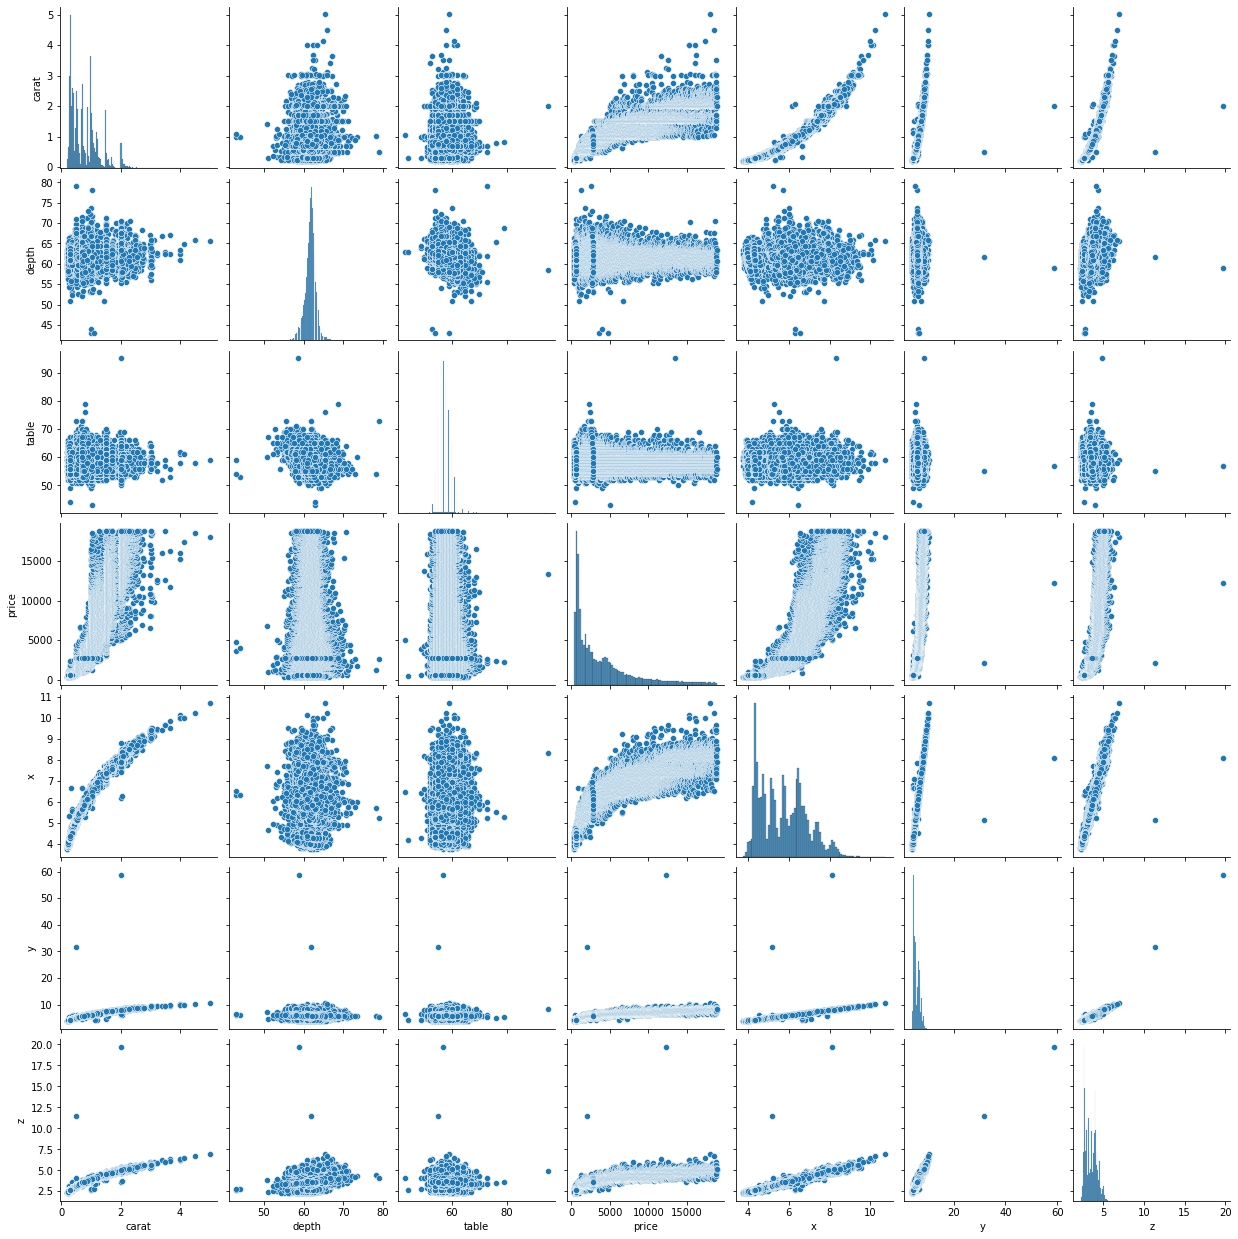

In [91]:
sns.pairplot(diamonds)

The plot shows that there are outliers, we can temporary remove them to see the plots and the relationships clearly

In [7]:
def GetMinMaxValues(data):
    IQR = data.quantile(0.75)-data.quantile(0.25)
    minValue = (data.quantile(.25))-(1.5*IQR)
    maxValue = (data.quantile(.75))+(1.5*IQR)
    return minValue,maxValue

xMinValue,xMaxValue = GetMinMaxValues(diamonds['x'])
yMinValue,yMaxValue = GetMinMaxValues(diamonds['y'])
zMinValue,zMaxValue = GetMinMaxValues(diamonds['z'])
caratMinValue,caratMaxValue = GetMinMaxValues(diamonds['carat'])

diamonds_without_outliers = diamonds[(diamonds['x'] > xMinValue) & (diamonds['x'] < xMaxValue) 
                                           & (diamonds['y'] > yMinValue) & (diamonds['y'] < yMaxValue) 
                                           & (diamonds['z'] > zMinValue) & (diamonds['z'] < zMaxValue)
                                           & (diamonds['carat'] > caratMinValue) & (diamonds['carat'] < caratMaxValue)  ] 

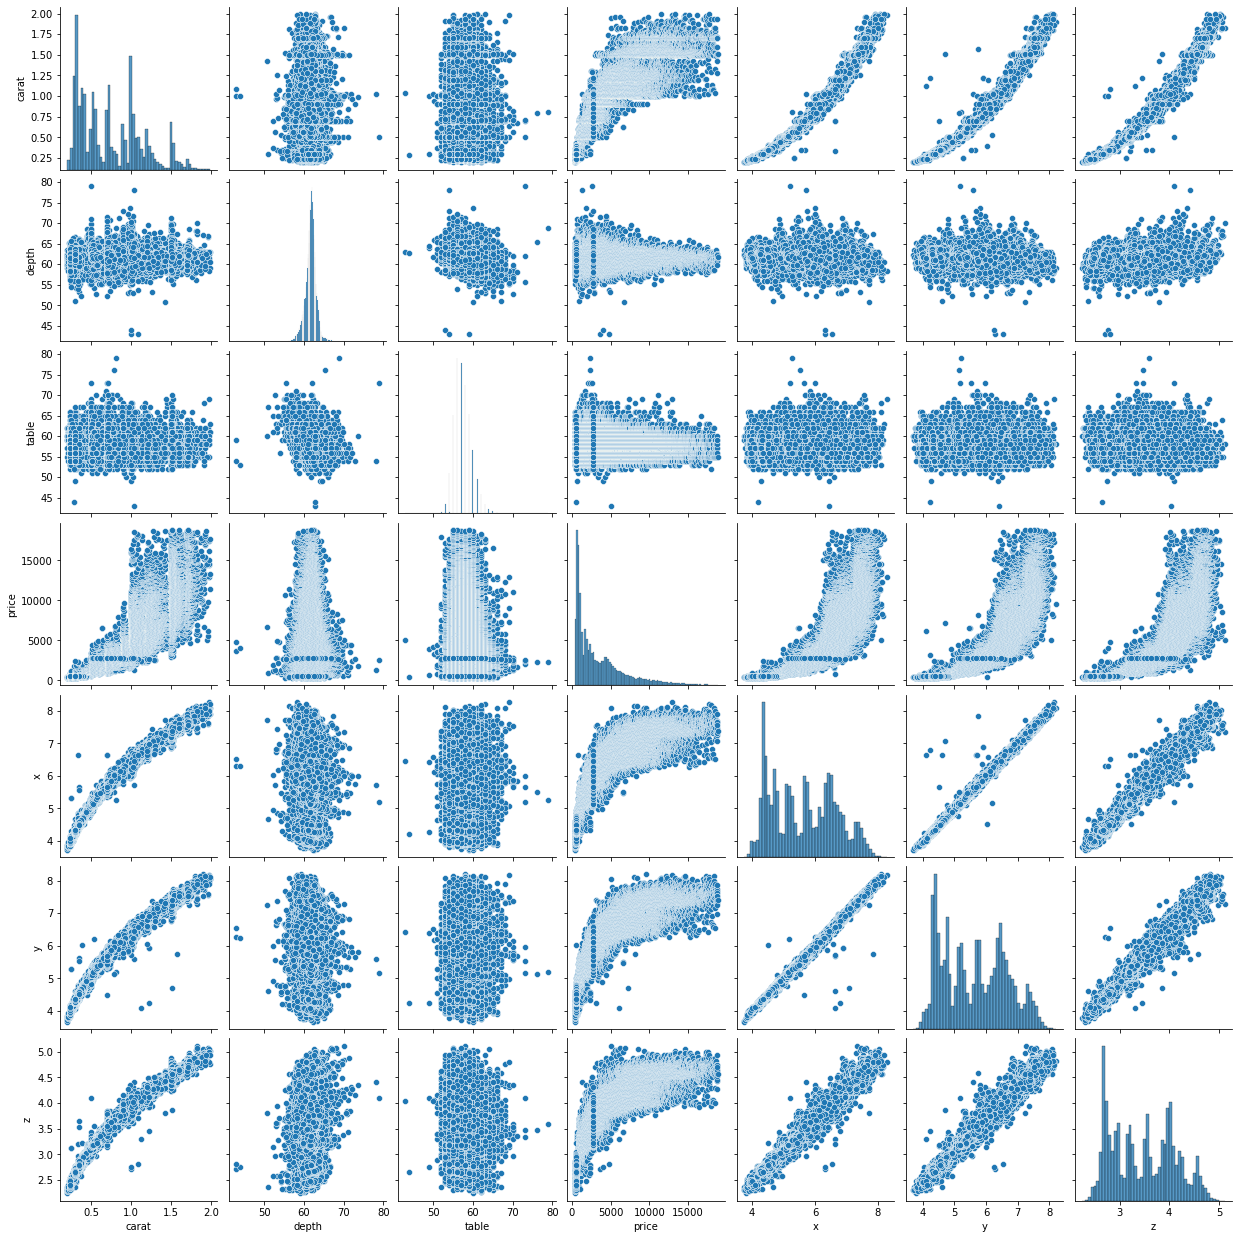

In [93]:
sns.pairplot(diamonds_without_outliers)

Correlations between data

<AxesSubplot:>

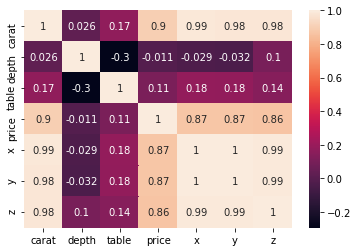

In [13]:
sns.heatmap(diamonds_without_outliers.corr(), annot=True)

Non-linear correlations for data

In [ ]:
sns.heatmap(diamonds_without_outliers.corr( method = 'spearman' ), annot=True)

As shown in the figure, the correlation between dimensions and the price are almost equal, we can try to combine them in one attribute called size

In [8]:
diamonds_with_size = diamonds_without_outliers.copy()
diamonds_with_size['size'] = round(diamonds['x'] * diamonds['y'] * diamonds['z'],2)
diamonds_with_size.head()

,carat,cut,color,clarity,depth,table,price,x,y,z,size
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.44,38.36
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31,34.51
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31,38.08
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63,46.72
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75,51.92


Check the correlations again

<AxesSubplot:>

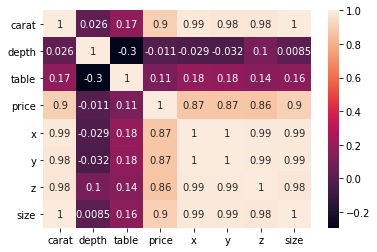

In [96]:
sns.heatmap(diamonds_with_size.corr(), annot=True )

Non-linear correlations with size

In [ ]:
sns.heatmap(diamonds_with_size.corr( method = 'spearman' ), annot=True)

Visualize the relationship between quantitative data and diamond price using scatter plots

<AxesSubplot:xlabel='carat', ylabel='price'>

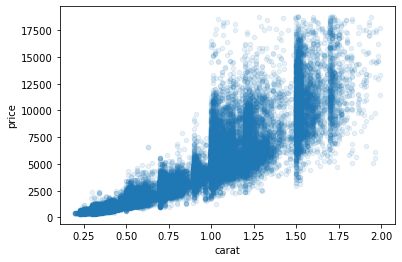

In [97]:
diamonds_without_outliers.plot(x = 'carat',y = 'price',kind = 'scatter', alpha = 0.1)

<AxesSubplot:xlabel='depth', ylabel='price'>

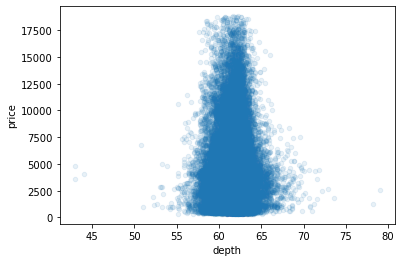

In [98]:
diamonds_without_outliers.plot(x = 'depth',y = 'price',kind = 'scatter', alpha = 0.1)

<AxesSubplot:xlabel='table', ylabel='price'>

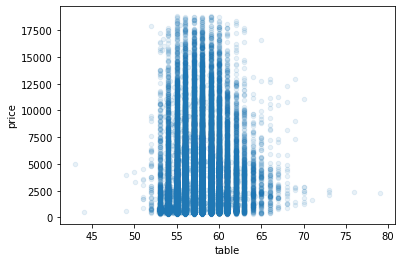

In [99]:
diamonds_without_outliers.plot(x = 'table',y = 'price',kind = 'scatter',alpha = 0.1)

<AxesSubplot:xlabel='x', ylabel='price'>

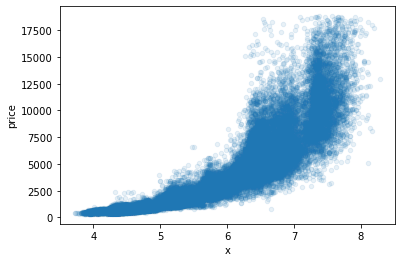

In [100]:
diamonds_without_outliers.plot(x = 'x',y = 'price',kind = 'scatter', alpha = 0.1)

<AxesSubplot:xlabel='y', ylabel='price'>

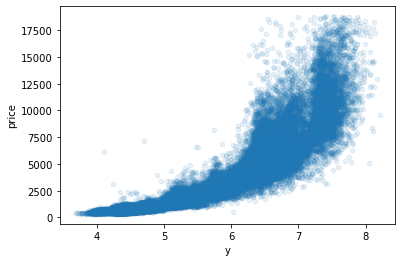

In [101]:
diamonds_without_outliers.plot(x = 'y',y = 'price',kind = 'scatter',alpha = 0.1)

<AxesSubplot:xlabel='z', ylabel='price'>

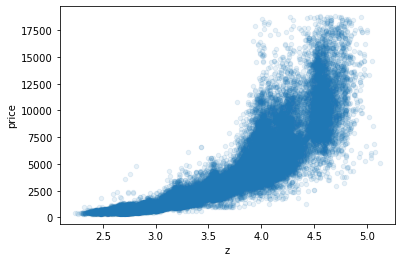

In [102]:
diamonds_without_outliers.plot(x = 'z',y = 'price',kind = 'scatter',alpha = 0.1)

<AxesSubplot:xlabel='size', ylabel='price'>

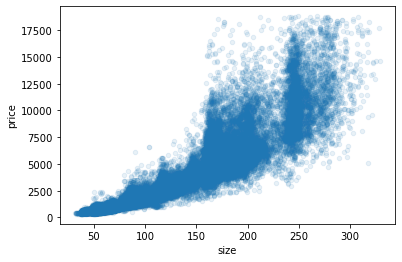

In [127]:
diamonds_with_size.plot(x = 'size',y = 'price',kind = 'scatter',alpha = 0.1)

Visualize the relationship between categorical data and diamond price using catplot

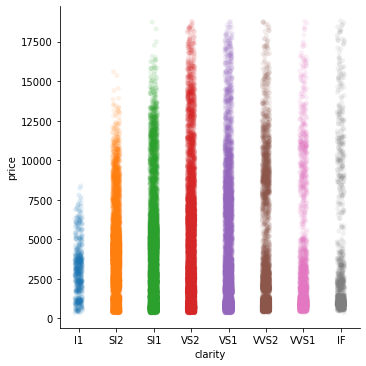

In [103]:
sns.catplot(x="clarity", y="price",order=["I1" , "SI2", "SI1", 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF'], data= diamonds_without_outliers,alpha = 0.1)

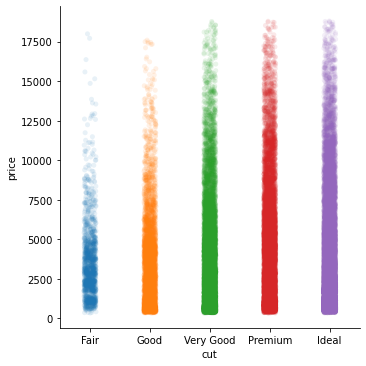

In [104]:
sns.catplot(x="cut", y="price",order=["Fair" , "Good", "Very Good", 'Premium', 'Ideal'], data= diamonds_without_outliers,alpha = 0.1)

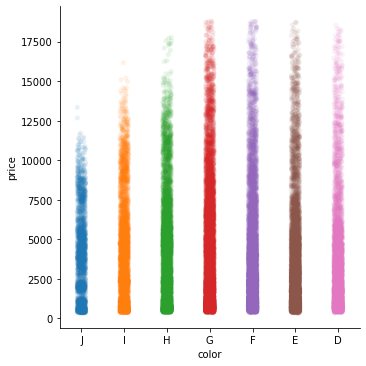

In [105]:
sns.catplot(x="color", y="price",order=['J','I','H','G','F','E','D'], data= diamonds_without_outliers,alpha = 0.1)

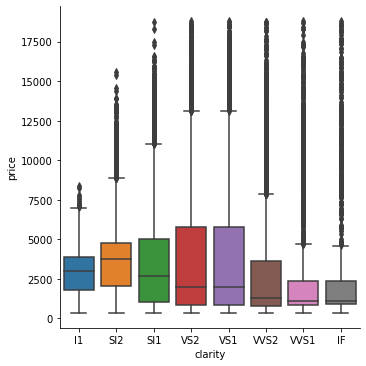

In [106]:
sns.catplot(x="clarity", y="price", order=["I1" , "SI2", "SI1", 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF'],data= diamonds_without_outliers, kind = 'box')

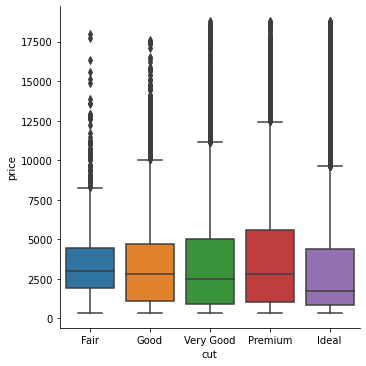

In [107]:
sns.catplot(x="cut", y="price",order=["Fair" , "Good", "Very Good", 'Premium', 'Ideal'],kind = 'box', data= diamonds_without_outliers)

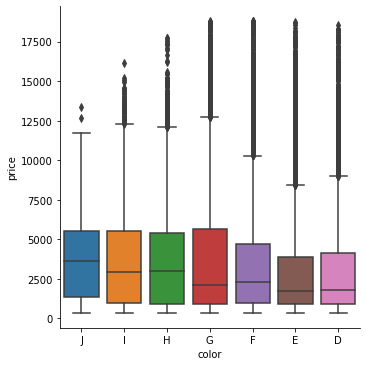

In [108]:
sns.catplot(x="color", y="price",order=['J','I','H','G','F','E','D'],kind = 'box', data= diamonds_without_outliers)

<AxesSubplot:xlabel='price', ylabel='Count'>

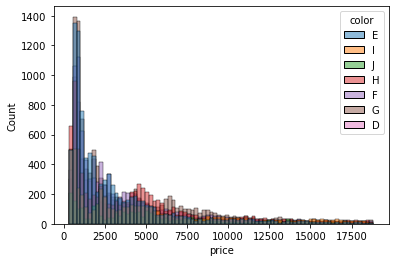

In [109]:
sns.histplot( hue= 'color',data=diamonds, x='price')

Create a Test Set

In [9]:
diamonds["carat_cat"] = pd.cut(diamonds["carat"],
bins=[0, 1, 2,3,4, np.inf],
labels=[1, 2, 3,4,5])
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(diamonds, diamonds["carat_cat"]):
    train_set = diamonds.iloc[train_index]
    test_set = diamonds.iloc[test_index]
    
diamonds = train_set.drop("price", axis=1)
diamonds_labels = train_set["price"].copy()

In [10]:
cat_attribs = ["cut","color","clarity"]
diamonds_num = diamonds.drop(cat_attribs, axis=1)
num_attribs = list(diamonds_num)


Create custom transformer to replace the dimensions with size

In [11]:
x_ix, y_ix,z_ix = [list(diamonds_num.columns).index(col) -1
    for col in ("x", "y","z")]

class ReplaceDimensionsWithSize(BaseEstimator, TransformerMixin):
    def __init__(self): 
        return None
    def fit(self, X, y=None):
        return self 
    def transform(self, X):
        size = X[:, x_ix] * X[:, y_ix] * X[:, z_ix]
        X = np.delete(X, [x_ix,y_ix,z_ix], axis=1)       
        return np.c_[X, size]

In [12]:
ordinal_encoder = OrdinalEncoder(categories=[['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'],['D','E','F','G','H','I','J'],['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']])    

Use pipeline to prepare the data, it has multi perparing stages:
    1- Fill the nan or null values using SimpleImputer with median startegy
    2- Calcualte the size of each diamond and add it to the data after  removing dimensions columns
    3- Use StandardScaler to scale numerical features
    4- USe OneHotEncoder to encode categorical features

In [14]:
num_pipeline = Pipeline([
 ('imputer', SimpleImputer(strategy="median")),
 ('replace_attr',ReplaceDimensionsWithSize()),
 ('std_scaler', StandardScaler())
])

Choose wether onehot encoder or ordinal encoder

In [15]:
full_pipeline = ColumnTransformer([
 ("num", num_pipeline, num_attribs),
 ("cat", ordinal_encoder,cat_attribs )])

In [ ]:
full_pipeline = ColumnTransformer([
 ("num", num_pipeline, num_attribs),
 ("cat", OneHotEncoder(),cat_attribs )])

In [16]:
diamonds_prepared = full_pipeline.fit_transform(diamonds)

# Train the model

RandomForestRegressor

In [17]:
forest_reg = RandomForestRegressor()
forest_reg.fit(diamonds_prepared, diamonds_labels)

RandomForestRegressor()

In [20]:
diamonds_predictions = forest_reg.predict(diamonds_prepared)
forest_mse = mean_squared_error(diamonds_labels, diamonds_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

204.2000620185971

Try the model on few instances form the traning set

In [119]:
some_data = diamonds.iloc[:5]
some_labels = diamonds_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", forest_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))


Predictions: [ 1846.59  1064.06 15878.88  6987.76  2844.98]
Labels: [1877, 1039, 15651, 7287, 2822]


Very accurate values!

LinearRegressor

In [18]:
lin_reg = LinearRegression()
lin_reg.fit(diamonds_prepared, diamonds_labels)


LinearRegression()

In [22]:
diamonds_predictions = lin_reg.predict(diamonds_prepared)
lin_mse = mean_squared_error(diamonds_labels, diamonds_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

1124.2546830371086

DecisionTreeRegressor

In [19]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(diamonds_prepared, diamonds_labels)

DecisionTreeRegressor()

In [24]:
diamonds_predictions = tree_reg.predict(diamonds_prepared)
tree_mse = mean_squared_error(diamonds_labels, diamonds_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

33.31850183647153

# Better Evaluation Using Cross-Validation

RandomForest

In [20]:
forest_scores = cross_val_score(forest_reg, diamonds_prepared, diamonds_labels,
scoring="neg_mean_squared_error", cv=10)
forest_rsme_scores = np.sqrt(-forest_scores)
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
display_scores(forest_rsme_scores)

Scores: [530.51877554 534.7515525  567.59912414 541.30818115 543.49396812
 560.78606127 543.95060803 555.38677071 504.89438959 552.61595856]
Mean: 543.5305389604702
Standard deviation: 16.865379396160105


LinearRegression

In [23]:
scores = cross_val_score(lin_reg, diamonds_prepared, diamonds_labels,
scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-scores)
lin_rmse_scores
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
display_scores(lin_rmse_scores)

Scores: [1202.99907942 1198.05725754 1221.21611871 1202.22408239 1205.38133508
 1191.16098534 1218.80879331 1227.0885467  1197.96639297 1278.90430892]
Mean: 1214.3806900367542
Standard deviation: 24.13393676980632


DecisionTreeRegressor

In [21]:
scores = cross_val_score(tree_reg, diamonds_prepared, diamonds_labels,
scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
tree_rmse_scores
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
display_scores(tree_rmse_scores)

Scores: [709.76805201 710.59781821 748.22989997 663.54296832 737.1356167
 751.53492877 716.24666907 742.59991422 700.10628057 731.2253969 ]
Mean: 721.0987544734644
Standard deviation: 25.49517437194529


Fine-Tune the model using GridSearch, we did it only on RandomForest, as it seemed the most promising.

In [22]:
from sklearn.model_selection import GridSearchCV
param_grid = [
 {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
 {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
 ]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
 scoring='neg_mean_squared_error',
return_train_score=True)
grid_search.fit(diamonds_prepared, diamonds_labels)


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [32]:
grid_search.best_params_


{'max_features': 8, 'n_estimators': 30}

In [33]:
grid_search.best_estimator_


RandomForestRegressor(max_features=8, n_estimators=30)

In [23]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)


716.4318300483228 {'max_features': 2, 'n_estimators': 3}
617.0033150992725 {'max_features': 2, 'n_estimators': 10}
579.9674927862943 {'max_features': 2, 'n_estimators': 30}
639.6604324099815 {'max_features': 4, 'n_estimators': 3}
571.1728164749593 {'max_features': 4, 'n_estimators': 10}
550.7334785075257 {'max_features': 4, 'n_estimators': 30}
626.7530174582663 {'max_features': 6, 'n_estimators': 3}
567.2361919944979 {'max_features': 6, 'n_estimators': 10}
549.742501395452 {'max_features': 6, 'n_estimators': 30}
627.7061580363742 {'max_features': 8, 'n_estimators': 3}
570.4572945246017 {'max_features': 8, 'n_estimators': 10}
553.3867832916125 {'max_features': 8, 'n_estimators': 30}
689.5838229738306 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
604.1715089789863 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
650.3211015302675 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
585.6543831265977 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}

Feature importance

In [24]:
feature_importances = grid_search.best_estimator_.feature_importances_

In [25]:
extra_attribs = ["size"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)


[(0.7517967949901833, 'carat'),
 (0.08031148026023864, 'x'),
 (0.06581873656021013, 'size'),
 (0.04545501142626454, 'table'),
 (0.0326233679536371, 'carat_cat'),
 (0.015180787300010877, 'y'),
 (0.005604607552505024, 'depth'),
 (0.0032092139569504415, 'z')]

Evaluate the System on the Test Set

In [26]:
final_model = grid_search.best_estimator_
X_test = test_set.drop("price", axis=1)
y_test = test_set["price"].copy()
X_test_prepared = full_pipeline.transform(X_test)

RandomForest

In [27]:
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

554.7747686079587

In [40]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
loc=squared_errors.mean(),
scale=stats.sem(squared_errors)))

array([543.47509979, 589.46007865])

LinearRegression

In [28]:
final_predictions = lin_reg.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

1206.1359969405264

In [42]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
loc=squared_errors.mean(),
scale=stats.sem(squared_errors)))

array([1077.47616603, 1156.17732286])

DecisionTreeRegressor

In [29]:
final_predictions = tree_reg.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

729.0241873279923

In [44]:
from scipy import stats
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
loc=squared_errors.mean(),
scale=stats.sem(squared_errors)))

array([713.79745741, 779.47562046])